# Bootcamp Exam

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format='svg'
%matplotlib inline

In [2]:
# Let's begin with loading the data
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="label")
X = (X - X.mean()) / X.std()  # data normalization
data = pd.concat([X, y], axis=1)

## Features Examination

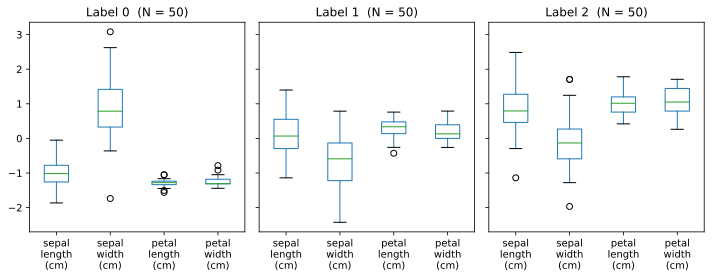

In [3]:
# Lets examine the features
fig, ax = plt.subplots(
    ncols=3, nrows=1, figsize=(10, 4), sharey=True
)  # share y for easy comparison

# plot the three labels speratley
for i in range(3):
    # plot a boxplot of the features
    data.loc[data["label"] == i, X.columns].plot.box(ax=ax[i])
    # change x tick labels to have spaces between words instead of default one line label
    ax[i].set_xticklabels([i.replace(" ", "\n") for i in X.columns])
    # add titles
    ax[i].set_title("Label "
                    + str(i)
                    + "  (N = "
                    + str((data.loc[data["label"] == i, X.columns]).shape[0])
                    + ")"
                    )

plt.tight_layout()
plt.show()

We can see that the petal length and width are relatively low for label 0. Also, we cn see that large sepal width is typical for that label. However, with large variance. 


## Hyperparameters Optimization and Models Fitting
1. We know that there are three clusters (according to the number of labels)
2. We have relatively small dataset which is equally distributed among the labels
Before applying any model, let's split the dataset to train-validation-test sets.
Since we are working with a relatively small dataset, we shall use stratified k-fold. k-fold helps us to overcome
the lack of data by repeating the validition process over different parts of the data, and startification
will help us maintaing the label ratios.

The validation size will be 25% of the training size.
In total, we will have 30 datapoints in the test set, and three folds of 90 datapoints of training set and 30 points of validation set.

We will apply three models (no preticular meaning for the order):

1) SVM, 2) k-nearest neighbors (KNN) and 3) Logistic regression (LR)
1) For the SVM classifier, We will use the validation set to optimize
the regularization (C) hyperparameter (keeping the exponent power (gamma) in the automatical scaling of sklearn).
Since the dataset is small, we will test only gaussian kernel (a well optimized gaussian kernel will always peform better than linear)

2) For the KNN classifier, we will optimize the number of neighbors

3) For the logistic regression, we will optimize the regularization parameter

In [4]:
# Parameters to optimize

# Regularizationtest C values for SVM  of 1e-3 to 1e3
Cs = np.logspace(-3, 4, 8)
Cs_lr = np.logspace(-2, 4, 7)  # Regularizationtest C values for LR
ks = np.arange(2, 30, 2)  # number of neighbors

# Since the dataset is balanced and there is no difference in cost of misclassification towards any of the classes, we will use accuracy.

In [5]:
# Model Fitting

scores_svc, scores_knn, scores_lr = {}, {}, {}  # cv scores dictonary
scores_test = {}  # test scores dictionary
y_tests, y_pred_tests = {}, {}  # save tests labels for confusion matrix

estimators = {}  # dictionary for estimator
confusions = {}  # dictionary confusion matrix

niter = 70

for iteration in range(niter):
    if iteration % 10 == 0:
        print(iteration, "out of", niter)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )  # Split to training and test set
    skf = StratifiedShuffleSplit(n_splits=3, test_size=0.25).split(
        X_train, y_train
    )  # k-fold (3-fold) which shuffles the data (since the data is sorted by labels).

    iteration_score_svc = np.zeros((len(Cs), 3))
    iteration_score_knn = np.zeros((len(ks), 3))
    iteration_score_lr = np.zeros((len(Cs_lr), 3))

    for i, (train_index, val_index) in enumerate(skf):
        # SVM loop
        for j, c in enumerate(Cs):
            clf = SVC(C=c)  # classifier
            clf.fit(X_train.iloc[train_index, :],
                    y_train.iloc[train_index])  # fit
            y_val_pred = clf.predict(X_train.iloc[val_index, :])  # predict
            iteration_score_svc[j, i] = accuracy_score(
                y_train.iloc[val_index], y_val_pred
            )  # calculate accuracy
        # LR loop
        for j, c in enumerate(Cs_lr):  #
            clf = LogisticRegression(C=c)
            clf.fit(X_train.iloc[train_index, :], y_train.iloc[train_index])
            y_val_pred = clf.predict(X_train.iloc[val_index, :])
            iteration_score_lr[j, i] = accuracy_score(
                y_train.iloc[val_index], y_val_pred
            )
        # KNN loop
        for j, k in enumerate(ks):
            clf = KNeighborsClassifier(k)
            clf.fit(X_train.iloc[train_index, :], y_train.iloc[train_index])
            y_val_pred = clf.predict(X_train.iloc[val_index, :])
            iteration_score_knn[j, i] = accuracy_score(
                y_train.iloc[val_index], y_val_pred
            )

    # save performance (for this exam, we will assume a small std between the folds)
    scores_svc[iteration] = iteration_score_svc.mean(axis=1)
    scores_knn[iteration] = iteration_score_knn.mean(axis=1)
    scores_lr[iteration] = iteration_score_lr.mean(axis=1)

    # retrain the models with the best hyperparameters
    estimators['knn_' +
               str(iteration)] = KNeighborsClassifier(n_neighbors=ks[scores_knn[iteration].argmax()]).fit(X_train, y_train)
    estimators['svc_' +
               str(iteration)] = SVC(C=Cs[scores_svc[iteration].argmax()]).fit(X_train, y_train)
    estimators['lr_' +
               str(iteration)] = LogisticRegression(C=Cs_lr[scores_lr[iteration].argmax()]).fit(X_train, y_train)

    # predict test set and store confusion matrix
    for method in ['knn', 'lr', 'svc']:
        y_pred_tests[method+'_'+str(iteration)] = estimators[method+'_' +
                                                             str(iteration)].predict(X_test)
        confusions[method+'_'+str(iteration)] = confusion_matrix(y_test,
                                                                 y_pred_tests[method+'_'+str(iteration)])
        # calculate test score
        scores_test[method+'_'+str(iteration)] = accuracy_score(
            y_test, y_pred_tests[method+'_'+str(iteration)])


# save the CV scores according to the hyperparameter being tuned
scores_svc = pd.DataFrame(scores_svc, index=Cs)
scores_knn = pd.DataFrame(scores_knn, index=ks)
scores_lr = pd.DataFrame(scores_lr, index=Cs_lr)

0 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

10 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

20 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

30 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

40 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

50 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


60 out of 70


C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\orsha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

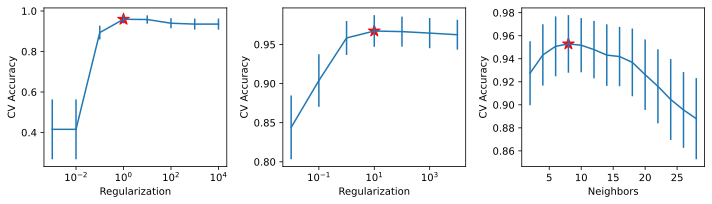

In [6]:
# Let us examine the hyperparameters of the CV

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3))

hyperparameter_name = ["Regularization", "Regularization", "Neighbors"]
hyperparameter_score = [scores_svc, scores_lr, scores_knn]
hyperparameter = [Cs, Cs_lr, ks]

for i in range(3):
    ax[i].errorbar(
        hyperparameter[i],
        hyperparameter_score[i].mean(axis=1),
        yerr=hyperparameter_score[i].std(axis=1),
    )
    ax[i].scatter(
        hyperparameter[i][hyperparameter_score[i].mean(axis=1).argmax()],
        hyperparameter_score[i].mean(axis=1).max(),
        marker="*",
        color="r",
        s=150,
    )
    ax[i].set_ylabel("CV Accuracy")
    ax[i].set_xlabel(hyperparameter_name[i])
    if i < 2:
        ax[i].set_xscale("log")

plt.tight_layout()
plt.show()

## Model Evaluation

<ipython-input-7-66c8d1ad53dc>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


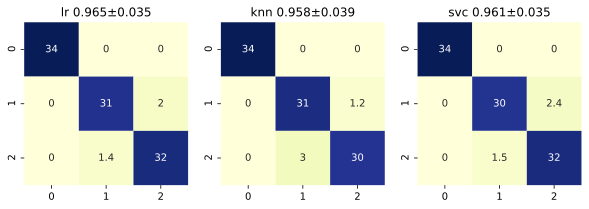

In [7]:
# Let's examine our test results by plotting our confusion matrix.
# To do so, we will sum our saved matrices

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 3))

for i, method in enumerate(['lr', 'knn', 'svc']):
    # combine to one confusion matrix
    cm = np.sum(np.array([confusions[x]
                          for x in confusions if method in x]), axis=0)
    # normalize confusion matrix (to percentage)
    cm = 100 * cm / np.sum(cm)
    # calculate mean and std of scores
    scores_method = [scores_test[x] for x in scores_test if method in x]
    scores_mean, scores_std = np.round(
        [np.mean(scores_method), np.std(scores_method)], 3)

    # plot matrix
    sns.heatmap(cm, cmap='YlGnBu', annot=True, cbar=False, ax=ax[i])
    ax[i].set_title(method + ' ' + str(scores_mean) + '±' + str(scores_std))
fig.show()

We can see that the three classifiers performence is essntially the same.
Since we used simple algorithms, this means that the data is easily separable with the given features.
We can further look on the coefficients of the logistic regression to see if any of the features
is specifically more important for the classification according to its weight.
The coefficient shape is 4(number of features) x 3 (number of classes). We will normalize
the features ratios for each model and see which are more important to determine each class.

In [8]:
# combine coefficients
label0 = {}
label1 = {}
label2 = {}

for iteration in range(niter):
    coeff = np.abs(estimators['lr_'+str(iteration)].coef_)
    coeff_max = coeff.max(axis=1)
    coeff_norm = (coeff.transpose()/coeff_max).transpose()
    label0[iteration] = coeff_norm[0]
    label1[iteration] = coeff_norm[1]
    label2[iteration] = coeff_norm[2]

label0 = pd.DataFrame(label0)
label1 = pd.DataFrame(label1)
label2 = pd.DataFrame(label2)

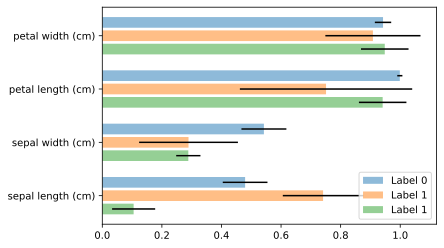

In [9]:
# Let's plot the importance for each label
plt.barh(y=np.arange(X.columns.shape[0])+0.25, width=label0.mean(
    axis=1), xerr=label0.std(axis=1), alpha=0.5, height=0.2, label='Label 0')

plt.barh(y=range(X.columns.shape[0]), width=label1.mean(
    axis=1), xerr=label1.std(axis=1), alpha=0.5, tick_label=X.columns, height=0.2, label='Label 1')

plt.barh(y=np.arange(X.columns.shape[0])-0.25, width=label2.mean(
    axis=1), xerr=label2.std(axis=1), alpha=0.5, height=0.2, label='Label 1')

plt.legend(loc='best')

We can see that
1) The sepal length has relatively low meaning for class number three
2) The petal features has larger weights than the sepal.
Other than those, it is hard to reach any conclusion.

Thanks for reading